In [ ]:
pip install ckiptagger

In [ ]:
# imports
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from scipy import sparse
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import xgboost as xgb
import numpy as np
import pickle
from tqdm import tqdm
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 先把我們需要的函數載入
ws = WS("/content/drive/MyDrive/大學報告/大數據與商業分析/期中專案/資料集/data (2)/data") # 斷詞
pos = POS("/content/drive/MyDrive/大學報告/大數據與商業分析/期中專案/資料集/data (2)/data") # 詞性標注
ner = NER("/content/drive/MyDrive/大學報告/大數據與商業分析/期中專案/資料集/data (2)/data") # 命名實體識別

def word_segmentation(contents, ws):
    word_sentence_list = ws(contents,
                        sentence_segmentation=True,
                        segment_delimiter_set={'?', '？', '!', '！', '。', ',','，', ';', ':', '、', ' ', '.'})
    # 標點符號
    punc = ['，', '。', '、', '：', '；', '？', '！', '「', '」', '（', '）', '『', '』', '—', '－', '～', '…', '‧', '《', '》', '〈', '〉', '﹏﹏']
    eng_punc = [',', '.', ':', ';', '?', '!', '(', ')', '[', ']', '&', '@', '#', '$', '%', '-', '_', '*', '/', '\\', '+', '=', '>', '<', '"', "'", '’', '‘', '“', '”', ' ']
    # 停用詞
    stop_words = ['全文', '日', '月', '年', 'br', '中央社', '公司', '上午', '下午', '日期']

    word_sentence_list = [[word for word in sentence if not any(char.isdigit() for char in word)] for sentence in word_sentence_list]
    word_sentence_list = [[word for word in sentence if word not in punc] for sentence in word_sentence_list]
    word_sentence_list = [[word for word in sentence if word not in eng_punc] for sentence in word_sentence_list]
    word_sentence_list = [[word for word in sentence if word not in stop_words] for sentence in word_sentence_list]

    return word_sentence_list

def preprocessing(df, days, ws):
    #df = df[df['label_day' + str(days)] != -1] # 把標籤為 -1 的 row 全部移除
    Y = lambda df, days: df['label_day' + str(days)].tolist() # 提取標籤
    contents = df['content'].tolist() # 提取正文內容
    # 對正文內容進行斷詞
    word_sentence_list = word_segmentation(contents, ws)
    # 取得 1-gram - 3-gram 的 tf-idf 特徵
    tv = TfidfVectorizer(ngram_range=(1, 3))
    tfidf = tv.fit_transform([' '.join(sentence) for sentence in word_sentence_list])
    # 取得前 1000 個特徵
    ch2 = SelectKBest(chi2, k=1000)
    X = ch2.fit_transform(tfidf, Y(df, days))
    # 將 foreign_investor_surplus, investment_trust_surplus, dealer_surplus 加入到 X
    X = sparse.hstack((X, sparse.csr_matrix(df[['foreign_investor_surplus', 'investment_trust_surplus', 'dealer_surplus']])))
    X = X.toarray()
    Y = np.ravel(np.array(Y(df,days)))

    return X, Y

/usr/local/lib/python3.10/dist-packages/ckiptagger/model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
/usr/local/lib/python3.10/dist-packages/ckiptagger/model_pos.py:56: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
/usr/local/lib/python3.10/dist-packages/ckiptagger/model_ner.py:57: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)


In [ ]:
# 创建模型实例
xgb_model = XGBClassifier(
    learning_rate=0.2,
    max_depth=4,
    n_estimators=300,
    subsample=1.0
)

svm_model = SVC(
    kernel='rbf',
    gamma='scale',
    C=10
)

rf_model = RandomForestClassifier(
    n_estimators=100,
    min_samples_split=5,
    min_samples_leaf=1,
    max_depth=None
)

# 定义Stacking模型
stacked_model = StackingClassifier(
    estimators=[
        ('xgboost', xgb_model),
        ('svm', svm_model),
        ('random_forest', rf_model)
    ],
    final_estimator=XGBClassifier()
)

In [ ]:
train_start_date_list = ['2022-03-01 00:00:00','2022-04-01 00:00:00','2022-05-01 00:00:00','2022-06-01 00:00:00','2022-07-01 00:00:00','2022-08-01 00:00:00','2022-09-01 00:00:00','2022-10-01 00:00:00','2022-11-01 00:00:00','2022-12-01 00:00:00','2023-01-01 00:00:00','2023-02-01 00:00:00','2023-03-01 00:00:00','2023-04-01 00:00:00','2023-05-01 00:00:00','2023-06-01 00:00:00','2023-07-01 00:00:00','2023-08-01 00:00:00','2023-09-01 00:00:00','2023-10-01 00:00:00','2023-11-01 00:00:00']
train_end_date_list = ['2022-05-31 00:00:00','2022-06-30 00:00:00','2022-07-31 00:00:00','2022-08-31 00:00:00','2022-09-30 00:00:00','2022-10-31 00:00:00','2022-11-30 00:00:00','2022-12-31 00:00:00','2023-01-31 00:00:00','2023-02-28 00:00:00','2023-03-31 00:00:00','2023-04-30 00:00:00','2023-05-31 00:00:00','2023-06-30 00:00:00','2023-07-31 00:00:00','2023-08-31 00:00:00','2023-09-30 00:00:00','2023-10-31 00:00:00','2023-11-30 00:00:00','2023-12-31 00:00:00','2024-01-31 00:00:00']

test_start_date_list = ['2022-06-01 00:00:00','2022-07-01 00:00:00','2022-08-01 00:00:00','2022-09-01 00:00:00','2022-10-01 00:00:00','2022-11-01 00:00:00','2022-12-01 00:00:00','2023-01-01 00:00:00','2023-02-01 00:00:00','2023-03-01 00:00:00','2023-04-01 00:00:00','2023-05-01 00:00:00','2023-06-01 00:00:00','2023-07-01 00:00:00','2023-08-01 00:00:00','2023-09-01 00:00:00','2023-10-01 00:00:00','2023-11-01 00:00:00','2023-12-01 00:00:00','2024-01-01 00:00:00','2024-02-01 00:00:00']
test_end_date_list = ['2022-06-30 00:00:00','2022-07-31 00:00:00','2022-08-31 00:00:00','2022-09-30 00:00:00','2022-10-31 00:00:00','2022-11-30 00:00:00','2022-12-31 00:00:00','2023-01-31 00:00:00','2023-02-28 00:00:00','2023-03-31 00:00:00','2023-04-30 00:00:00','2023-05-31 00:00:00','2023-06-30 00:00:00','2023-07-31 00:00:00','2023-08-31 00:00:00','2023-09-30 00:00:00','2023-10-31 00:00:00','2023-11-30 00:00:00','2023-12-31 00:00:00','2024-01-31 00:00:00','2024-02-18 00:00:00']

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/大學報告/大數據與商業分析/期中專案/資料集/news_filtered_merged.csv')

# 將日期欄位轉換為日期時間類型
data['date'] = pd.to_datetime(data['date'])

# 定義每個時段的長度（以天為單位）
period_length = 90  # 90天為一個時段

# 初始化結果列表，用於存放每個時段的預測結果和準確率
results = []

# 初始化混淆矩陣
total_conf_matrix = np.zeros((3, 3))

# 設定起始日期為資料中最小日期
start_date = data['date'].min()

# 限制測試次數用
i = 0


# 分段處理資料
with tqdm(total = 21) as pbar:
    while pd.to_datetime(test_end_date_list[i]) <= data['date'].max():

        # 取得該時段的結束日期
        #end_date = start_date + pd.Timedelta(days=period_length - 1)
        train_start_date = pd.to_datetime(train_start_date_list[i])
        train_end_date = pd.to_datetime(train_end_date_list[i])
        test_start_date = pd.to_datetime(test_start_date_list[i])
        test_end_date = pd.to_datetime(test_end_date_list[i])


        # 取出該時段的資料
        train_period_data = data[(data['date'] >= train_start_date) & (data['date'] <= train_end_date)]
        test_period_data = data[(data['date'] >= test_start_date) & (data['date'] <= test_end_date)]

        # 準備特徵和標籤
        X_train, y_train = preprocessing(train_period_data, 1, ws)
        X_test, y_test = preprocessing(test_period_data, 1, ws)

        #y = np.ravel(np.array(y))
        #X = X.toarray()

        # 切分資料為訓練集和測試集（按照時間順序）
        #split_index = int(len(X) * 0.8)  # 取前80%作為訓練集
        #X_train, X_test = X[:split_index], X[split_index:]
        #y_train, y_test = y[:split_index], y[split_index:]

        #with open("/content/drive/MyDrive/大學報告/大數據與商業分析/期中專案/model.pkl", 'rb') as f:
        #    model = pickle.load(f)

        # 訓練模型
        stacked_model.fit(X_train, y_train)

        # 進行預測
        y_pred = stacked_model.predict(X_test)

        # 計算準確率
        accuracy = accuracy_score(y_test, y_pred)

        # 計算混淆矩陣
        conf_matrix = confusion_matrix(y_test, y_pred)

        # 累加混淆矩陣
        total_conf_matrix += conf_matrix

        # 記錄結果
        results.append({'Start Train Date': train_start_date, 'End Train Date': train_end_date, 'Start Test Date': test_start_date, 'End Test Date': test_end_date, 'Accuracy': accuracy})
        print('Start Train Date:', train_start_date, 'End Train Date:', train_end_date, 'Start Test Date:', test_start_date, 'End Test Date:', test_end_date, 'Accuracy:', accuracy)

        # 更新起始日期為下一個時段的起始日期
        #start_date = start_date + pd.Timedelta(days=period_length)
        i += 1
        pbar.update(1)

# 輸出結果
for result in results:
    print("Period Start:", result['Start Train Date'], "Period End:", result['End Train Date'], "Accuracy:", result['Accuracy'])

# 計算總準確率
total_accuracy = sum(result['Accuracy'] for result in results) / len(results)
print("Total accuracy:", total_accuracy)

# 輸出總混淆矩陣
print("Total Confusion Matrix:")
print(total_conf_matrix)

  5%|▍         | 1/21 [08:41<2:53:53, 521.67s/it]

Start Train Date: 2022-03-01 00:00:00 End Train Date: 2022-05-31 00:00:00 Start Test Date: 2022-06-01 00:00:00 End Test Date: 2022-06-30 00:00:00 Accuracy: 0.49160671462829736


 10%|▉         | 2/21 [15:04<2:19:25, 440.29s/it]

Start Train Date: 2022-04-01 00:00:00 End Train Date: 2022-06-30 00:00:00 Start Test Date: 2022-07-01 00:00:00 End Test Date: 2022-07-31 00:00:00 Accuracy: 0.5068493150684932


 14%|█▍        | 3/21 [21:22<2:03:31, 411.75s/it]

Start Train Date: 2022-05-01 00:00:00 End Train Date: 2022-07-31 00:00:00 Start Test Date: 2022-08-01 00:00:00 End Test Date: 2022-08-31 00:00:00 Accuracy: 0.2558922558922559


 19%|█▉        | 4/21 [26:56<1:47:58, 381.07s/it]

Start Train Date: 2022-06-01 00:00:00 End Train Date: 2022-08-31 00:00:00 Start Test Date: 2022-09-01 00:00:00 End Test Date: 2022-09-30 00:00:00 Accuracy: 0.2582781456953642


 24%|██▍       | 5/21 [31:43<1:32:33, 347.08s/it]

Start Train Date: 2022-07-01 00:00:00 End Train Date: 2022-09-30 00:00:00 Start Test Date: 2022-10-01 00:00:00 End Test Date: 2022-10-31 00:00:00 Accuracy: 0.4146341463414634


 29%|██▊       | 6/21 [36:45<1:22:55, 331.71s/it]

Start Train Date: 2022-08-01 00:00:00 End Train Date: 2022-10-31 00:00:00 Start Test Date: 2022-11-01 00:00:00 End Test Date: 2022-11-30 00:00:00 Accuracy: 0.2745762711864407


 33%|███▎      | 7/21 [42:00<1:16:05, 326.08s/it]

Start Train Date: 2022-09-01 00:00:00 End Train Date: 2022-11-30 00:00:00 Start Test Date: 2022-12-01 00:00:00 End Test Date: 2022-12-31 00:00:00 Accuracy: 0.37105263157894736


 38%|███▊      | 8/21 [46:44<1:07:45, 312.71s/it]

Start Train Date: 2022-10-01 00:00:00 End Train Date: 2022-12-31 00:00:00 Start Test Date: 2023-01-01 00:00:00 End Test Date: 2023-01-31 00:00:00 Accuracy: 0.6535433070866141


 43%|████▎     | 9/21 [51:19<1:00:10, 300.90s/it]

Start Train Date: 2022-11-01 00:00:00 End Train Date: 2023-01-31 00:00:00 Start Test Date: 2023-02-01 00:00:00 End Test Date: 2023-02-28 00:00:00 Accuracy: 0.25


 48%|████▊     | 10/21 [56:29<55:40, 303.72s/it] 

Start Train Date: 2022-12-01 00:00:00 End Train Date: 2023-02-28 00:00:00 Start Test Date: 2023-03-01 00:00:00 End Test Date: 2023-03-31 00:00:00 Accuracy: 0.4873417721518987


 52%|█████▏    | 11/21 [1:01:11<49:30, 297.09s/it]

Start Train Date: 2023-01-01 00:00:00 End Train Date: 2023-03-31 00:00:00 Start Test Date: 2023-04-01 00:00:00 End Test Date: 2023-04-30 00:00:00 Accuracy: 0.2289156626506024


 57%|█████▋    | 12/21 [1:07:18<47:46, 318.50s/it]

Start Train Date: 2023-02-01 00:00:00 End Train Date: 2023-04-30 00:00:00 Start Test Date: 2023-05-01 00:00:00 End Test Date: 2023-05-31 00:00:00 Accuracy: 0.3120567375886525


 62%|██████▏   | 13/21 [1:14:22<46:44, 350.57s/it]

Start Train Date: 2023-03-01 00:00:00 End Train Date: 2023-05-31 00:00:00 Start Test Date: 2023-06-01 00:00:00 End Test Date: 2023-06-30 00:00:00 Accuracy: 0.43309002433090027


 67%|██████▋   | 14/21 [1:20:59<42:31, 364.52s/it]

Start Train Date: 2023-04-01 00:00:00 End Train Date: 2023-06-30 00:00:00 Start Test Date: 2023-07-01 00:00:00 End Test Date: 2023-07-31 00:00:00 Accuracy: 0.23391812865497075


 71%|███████▏  | 15/21 [1:28:10<38:27, 384.58s/it]

Start Train Date: 2023-05-01 00:00:00 End Train Date: 2023-07-31 00:00:00 Start Test Date: 2023-08-01 00:00:00 End Test Date: 2023-08-31 00:00:00 Accuracy: 0.21515892420537897


 76%|███████▌  | 16/21 [1:34:55<32:33, 390.66s/it]

Start Train Date: 2023-06-01 00:00:00 End Train Date: 2023-08-31 00:00:00 Start Test Date: 2023-09-01 00:00:00 End Test Date: 2023-09-30 00:00:00 Accuracy: 0.3917910447761194


 81%|████████  | 17/21 [1:40:57<25:27, 381.92s/it]

Start Train Date: 2023-07-01 00:00:00 End Train Date: 2023-09-30 00:00:00 Start Test Date: 2023-10-01 00:00:00 End Test Date: 2023-10-31 00:00:00 Accuracy: 0.33035714285714285


 86%|████████▌ | 18/21 [1:47:02<18:50, 376.98s/it]

Start Train Date: 2023-08-01 00:00:00 End Train Date: 2023-10-31 00:00:00 Start Test Date: 2023-11-01 00:00:00 End Test Date: 2023-11-30 00:00:00 Accuracy: 0.32054794520547947


 90%|█████████ | 19/21 [1:53:34<12:42, 381.38s/it]

Start Train Date: 2023-09-01 00:00:00 End Train Date: 2023-11-30 00:00:00 Start Test Date: 2023-12-01 00:00:00 End Test Date: 2023-12-31 00:00:00 Accuracy: 0.2396694214876033


 95%|█████████▌| 20/21 [2:01:11<06:44, 404.07s/it]

Start Train Date: 2023-10-01 00:00:00 End Train Date: 2023-12-31 00:00:00 Start Test Date: 2024-01-01 00:00:00 End Test Date: 2024-01-31 00:00:00 Accuracy: 0.06666666666666667


100%|██████████| 21/21 [2:08:22<00:00, 366.77s/it]

Start Train Date: 2023-11-01 00:00:00 End Train Date: 2024-01-31 00:00:00 Start Test Date: 2024-02-01 00:00:00 End Test Date: 2024-02-18 00:00:00 Accuracy: 0.5535714285714286


IndexError: list index out of range

In [ ]:
# 輸出結果
for result in results:
    print("Period Start:", result['Start Train Date'], "Period End:", result['End Train Date'], "Accuracy:", result['Accuracy'])

# 計算總準確率
total_accuracy = sum(result['Accuracy'] for result in results) / len(results)
print("Total accuracy:", total_accuracy)

# 輸出總混淆矩陣
print("Total Confusion Matrix:")
print(total_conf_matrix)

Period Start: 2022-03-01 00:00:00 Period End: 2022-05-31 00:00:00 Accuracy: 0.49160671462829736
Period Start: 2022-04-01 00:00:00 Period End: 2022-06-30 00:00:00 Accuracy: 0.5068493150684932
Period Start: 2022-05-01 00:00:00 Period End: 2022-07-31 00:00:00 Accuracy: 0.2558922558922559
Period Start: 2022-06-01 00:00:00 Period End: 2022-08-31 00:00:00 Accuracy: 0.2582781456953642
Period Start: 2022-07-01 00:00:00 Period End: 2022-09-30 00:00:00 Accuracy: 0.4146341463414634
Period Start: 2022-08-01 00:00:00 Period End: 2022-10-31 00:00:00 Accuracy: 0.2745762711864407
Period Start: 2022-09-01 00:00:00 Period End: 2022-11-30 00:00:00 Accuracy: 0.37105263157894736
Period Start: 2022-10-01 00:00:00 Period End: 2022-12-31 00:00:00 Accuracy: 0.6535433070866141
Period Start: 2022-11-01 00:00:00 Period End: 2023-01-31 00:00:00 Accuracy: 0.25
Period Start: 2022-12-01 00:00:00 Period End: 2023-02-28 00:00:00 Accuracy: 0.4873417721518987
Period Start: 2023-01-01 00:00:00 Period End: 2023-03-31 00:00

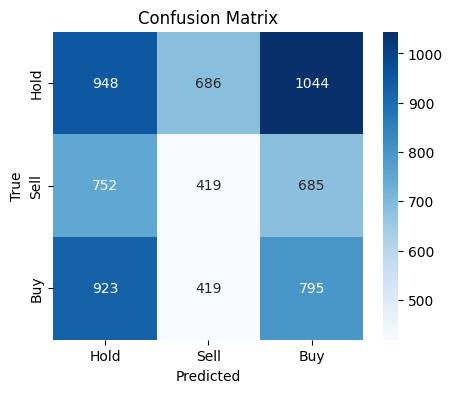

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Define class labels
labels = ['Hold', 'Sell', 'Buy']

# Plot the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(total_conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import pickle

with open("/content/drive/MyDrive/大學報告/大數據與商業分析/期中專案/model.pkl", 'rb') as f:
      model = pickle.load(f)